In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Let's train the model again first - to use its results later in this notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data/03-04-classification-telco-customer-churn-data.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)


In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']

train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer()
dv_small.fit(train_dict_small)

X_train_small = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_train_small, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_val_small = dv_small.transform(val_dict_small)

y_val_pred_small = model_small.predict_proba(X_val_small)[:, 1]

### Accuracy 

In [11]:
churn_val = y_val_pred >= 0.5
np.mean(churn_val == y_val)

0.8016129032258065

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_val_pred>=0.5)

0.8016129032258065

In [14]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for theta in thresholds:
    acc = accuracy_score(y_val, y_val_pred >= theta)
    accuracies.append(round(acc, 4))

pd.DataFrame(zip(thresholds, accuracies), columns=['Threshold', 'Accuracy'])

,Threshold,Accuracy
0,0.00,0.2613
1,0.05,0.5011
2,0.10,0.5946
3,0.15,0.6403
4,0.20,0.6898
5,0.25,0.7296
6,0.30,0.7548
7,0.35,0.7672
8,0.40,0.7817
9,0.45,0.7952


Text(0.5, 1.0, 'Accuracy vs. Threshold')

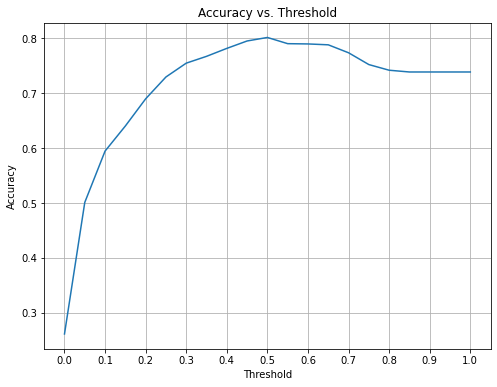

In [15]:
plt.figure(figsize=(8, 6))

plt.plot(thresholds, accuracies)
plt.grid()
plt.xticks(np.linspace(0, 1, 11))
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')

In [16]:
# Accuracy of the smaller model (trained with smaller subset of features)
accuracy_score(y_val, y_val_pred_small >= 0.5)

0.7672043010752688

In [17]:
# A baseline model: always predict the majority class; here: always predict non-churn
y_val_baseline = np.repeat(False, len(y_val))
accuracy_score(y_val, y_val_baseline)

0.7387096774193549

### Confusion Matrix

In [18]:
true_positive = np.sum((y_val_pred >= 0.5) & (y_val == 1))
false_positive = np.sum((y_val_pred >= 0.5) & (y_val == 0))
false_negative = np.sum((y_val_pred < 0.5) & (y_val == 1))
true_negative = np.sum((y_val_pred < 0.5) & (y_val == 0))

In [19]:
confusion_table = np.array(
    # Predic neg     Pos
    [[true_negative, false_positive], # Actual neg
     [false_negative, true_positive]] # Actual pos
)

confusion_table

array([[1202,  172],
       [ 197,  289]])

### Precision and Recall

In [20]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Precision: 0.6269, Recall: 0.5947


### ROC and AUC
ROC: Receiver Operating characteristic

AUC: Area under Curve

In [21]:
scores = []

thresholds = np.linspace(0, 1, 101)

for theta in thresholds:
    tp = np.sum((y_val_pred >= theta) & (y_val == 1))
    fp = np.sum((y_val_pred >= theta) & (y_val == 0))
    fn = np.sum((y_val_pred < theta) & (y_val == 1))
    tn = np.sum((y_val_pred < theta) & (y_val == 0))
    scores.append([theta, tp, fp, fn, tn])

df_scores = pd.DataFrame(scores, columns=['Threshold', 'TP', 'FP', 'FN', 'TN'])
df_scores[::10]

,Threshold,TP,FP,FN,TN
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [22]:
# True Positive Rate (= Recall), False Positive Rate (= false positives among negatives)
df_scores['TPR'] = df_scores['TP'] / (df_scores['TP'] + df_scores['FN'])
df_scores['FPR'] = df_scores['FP'] / (df_scores['FP'] + df_scores['TN'])

df_scores[::10]

,Threshold,TP,FP,FN,TN,TPR,FPR
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


In [23]:
def get_tpr_fpr_dataframe(y_val, y_val_pred, n_thresholds=101):
    scores = []
    
    thresholds = np.linspace(0, 1, n_thresholds)

    for theta in thresholds:
        tp = np.sum((y_val_pred >= theta) & (y_val == 1))
        fp = np.sum((y_val_pred >= theta) & (y_val == 0))
        fn = np.sum((y_val_pred < theta) & (y_val == 1))
        tn = np.sum((y_val_pred < theta) & (y_val == 0))
        scores.append([theta, tp, fp, fn, tn])
    
    df_scores = pd.DataFrame(
        scores, 
        columns=['Threshold', 'TP', 'FP', 'FN', 'TN'])

    df_scores['TPR'] = df_scores['TP']/(df_scores['TP'] + df_scores['FN'])
    df_scores['FPR'] = df_scores['FP']/(df_scores['FP'] + df_scores['TN'])

    return df_scores

In [24]:
model_scores = get_tpr_fpr_dataframe(y_val, y_val_pred)
model_small_scores = get_tpr_fpr_dataframe(y_val, y_val_pred_small)

In [25]:
## Let's create a random baseline classifier for comparison
np.random.seed(1)
y_val_pred_random = np.random.uniform(0, 1, size=len(y_val))

model_random_scores = get_tpr_fpr_dataframe(y_val, y_val_pred_random)

In [26]:
## Let's create an Ideal classifier
n_neg = np.sum((y_val == 0))
n_pos = np.sum((y_val == 1))

y_val_ideal = np.repeat([0, 1], [n_neg, n_pos])
y_val_pred_ideal = np.linspace(0, 1, n_neg + n_pos)

model_ideal_scores = get_tpr_fpr_dataframe(y_val_ideal, y_val_pred_ideal)

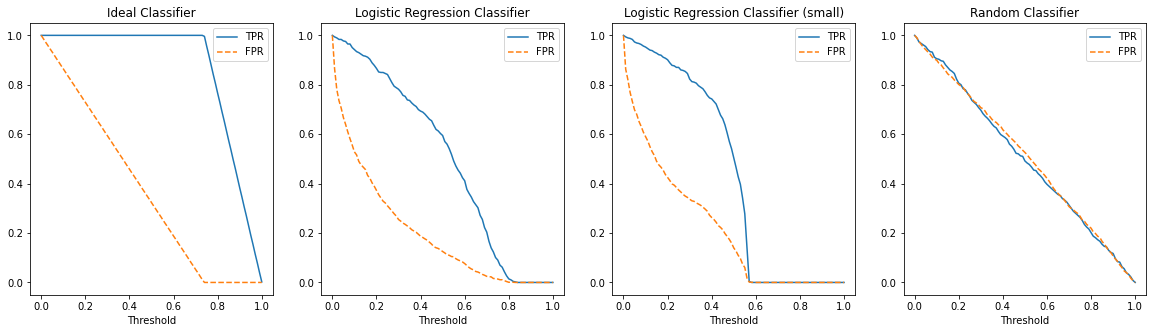

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].plot(model_ideal_scores['Threshold'], model_ideal_scores['TPR'], linestyle='solid', label='TPR')
ax[0].plot(model_ideal_scores['Threshold'], model_ideal_scores['FPR'], linestyle='dashed', label='FPR')
ax[0].legend()
ax[0].set_title('Ideal Classifier')
ax[0].set_xlabel('Threshold')

ax[1].plot(model_scores['Threshold'], model_scores['TPR'], linestyle='solid', label='TPR')
ax[1].plot(model_scores['Threshold'], model_scores['FPR'], linestyle='dashed', label='FPR')
ax[1].legend()
ax[1].set_title('Logistic Regression Classifier')
ax[1].set_xlabel('Threshold')

ax[2].plot(model_small_scores['Threshold'], model_small_scores['TPR'], linestyle='solid', label='TPR')
ax[2].plot(model_small_scores['Threshold'], model_small_scores['FPR'], linestyle='dashed', label='FPR')
ax[2].legend()
ax[2].set_title('Logistic Regression Classifier (small)')
ax[2].set_xlabel('Threshold')

ax[3].plot(model_random_scores['Threshold'], model_random_scores['TPR'], linestyle='solid', label='TPR')
ax[3].plot(model_random_scores['Threshold'], model_random_scores['FPR'], linestyle='dashed', label='FPR')
ax[3].legend()
ax[3].set_title('Random Classifier')
ax[3].set_xlabel('Threshold')

plt.show()

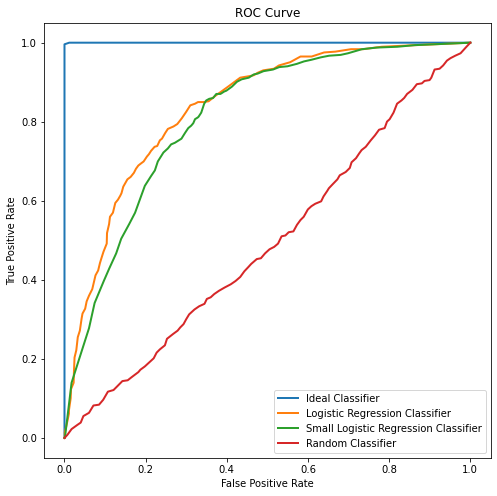

In [28]:
## ROC curve 

plt.figure(figsize=(8, 8))

plt.plot(model_ideal_scores['FPR'], model_ideal_scores['TPR'], linestyle='solid', linewidth=2, label='Ideal Classifier')
plt.plot(model_scores['FPR'], model_scores['TPR'], linestyle='solid', linewidth=2, label='Logistic Regression Classifier')
plt.plot(model_small_scores['FPR'], model_small_scores['TPR'], linestyle='solid', linewidth=2, label='Small Logistic Regression Classifier')
plt.plot(model_random_scores['FPR'], model_random_scores['TPR'], linestyle='solid', linewidth=2, label='Random Classifier')

plt.legend()

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

In [30]:
print("Area under ROC curve (ROC_AUC Score):")
print(f"Ideal classifier:\t\t\t{roc_auc_score(y_val_ideal, y_val_pred_ideal):.4f}")
print(f"Logistic Regression classifier:\t\t{roc_auc_score(y_val, y_val_pred):.4f}")
print(f"Small Logistic Regression classifier:\t{roc_auc_score(y_val, y_val_pred_small):.4f}")
print(f"Random classifier:\t\t\t{roc_auc_score(y_val, y_val_pred_random):.4f}")

Area under ROC curve (ROC_AUC Score):
Ideal classifier:			1.0000
Logistic Regression classifier:		0.8363
Small Logistic Regression classifier:	0.8118
Random classifier:			0.4932


### K-fold cross validation

In [31]:
def train(df, y):
    cat_num = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat_num)

    X = dv.transform(cat_num)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model 

In [32]:
def predict(df, dv, model):
    cat_num = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(cat_num)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred 

In [33]:
from sklearn.model_selection import KFold

In [34]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [35]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):

    df_train = df_train_full.iloc[train_idx]
    y_train = df_train['churn'].values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val['churn'].values

    dv, model = train(df_train, y_train)
    y_val_pred = predict(df_val, dv, model)

    roc_auc = roc_auc_score(y_val, y_val_pred)
    aucs.append(roc_auc)

aucs

[0.8493392490816277,
 0.8420018564356436,
 0.8590269587894291,
 0.8330260883877869,
 0.8242400744416873,
 0.840959040959041,
 0.8437154021491371,
 0.8223513598987982,
 0.8450274195938936,
 0.8611811367685119]

In [36]:
print(f"auc = {np.mean(aucs):.4f} +/- {np.std(aucs):.4f}")

auc = 0.8421 +/- 0.0123


### Tuing the parameter C using cross validation

In [37]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model 

In [38]:
nfolds = 5

kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

C_arr = [0.001, 0.01, 0.1, 0.5, 1, 10]

for C in C_arr:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        y_train = df_train['churn'].values

        df_val = df_train_full.iloc[val_idx]
        y_val = df_val['churn'].values

        dv, model = train(df_train, y_train, C=C)
        y_val_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)
    
    print(f"C={C}, auc = {np.mean(aucs):.4f} +/- {np.std(aucs):.4f}")

C=0.001, auc = 0.8250 +/- 0.0131
C=0.01, auc = 0.8393 +/- 0.0088
C=0.1, auc = 0.8408 +/- 0.0075
C=0.5, auc = 0.8412 +/- 0.0074
C=1, auc = 0.8411 +/- 0.0074
C=10, auc = 0.8412 +/- 0.0074


### Use the "best" C to train again: train on the full training set (previously, train + val)

In [39]:
CStar = 0.5

y_train = df_train_full['churn'].values

y_test = df_test['churn'].values

dv, model = train(df_train_full, y_train, C=CStar)
y_test_pred = predict(df_test, dv, model)

auc_test = roc_auc_score(y_test, y_test_pred)
auc_test

0.8581188317245713